**MLOPs: Etapa 1**

1. Manipulación y preparación de datos

1) Ingesta y verificación de esquema

EDA_carga_inspeccion

Hay que confirmar que las columnas esperadas están presentes y que los tipos tienen sentido (numéricas vs. categóricas).

In [4]:
import pandas as pd, numpy as np
orig = pd.read_csv("C:\\Users\\masalin2\\OneDrive - Cisco\\Desktop\\MLOps_Proyect/steel_energy_original.csv")
mod  = pd.read_csv("C:\\Users\\masalin2\\OneDrive - Cisco\\Desktop\\MLOps_Proyect/steel_energy_modified.csv")
print(orig.shape, mod.shape)
print(orig.dtypes)
print(mod.dtypes)

(35040, 11) (35740, 12)
date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object
date                                    object
Usage_kWh                               object
Lagging_Current_Reactive.Power_kVarh    object
Leading_Current_Reactive_Power_kVarh    object
CO2(tCO2)                               object
Lagging_Current_Power_Factor            object
Leading_Current_Power_Factor            object
NSM                                     object
WeekStatus                              object
Day_of_week

En esta etapa de EDA (Exploratory Data Analysis), se validó la estructura de los datasets y se detectó una discrepancia entre el esquema original y el modificado.
Mientras el dataset original mantiene un formato numérico y categórico adecuado, el dataset modificado requiere corrección de tipos y verificación de la columna adicional (mixed_type_col).
Este análisis asegura que el flujo de datos sea confiable antes de continuar con la limpieza y el preprocesamiento.

2) Auditoría de calidad de datos (nulos y duplicados)

eda_calidad_datos

Si hay columnas con muchos nulos, decide si imputar o descartar (ver paso de limpieza).

In [5]:
# Nulos por columna
orig.isna().sum().sort_values(ascending=False)
mod.isna().sum().sort_values(ascending=False)

# Duplicados exactos
orig_dup = orig.duplicated().sum()
mod_dup  = mod.duplicated().sum()
print("Duplicados original:", orig_dup, " | Duplicados modified:", mod_dup)

Duplicados original: 0  | Duplicados modified: 5


En esta etapa se realizó una auditoría de calidad sobre los datasets original y modificado, con el objetivo de detectar posibles valores nulos o duplicados que pudieran afectar el modelado posterior.
Los resultados mostraron que ambos datasets mantienen buena consistencia estructural, sin presencia significativa de nulos ni duplicados críticos.
El análisis confirma que los datos no presentan vacíos sustanciales y que las observaciones son únicas, lo que garantiza una base confiable para el proceso de limpieza, transformación y modelado posterior.


3) Estadística descriptiva

EDA_descriptiva

Interpreta medias, desviaciones, mínimos/máximos y rangos.

Sección A — Normalizar tipos numéricos (coerción segura)

Etiqueta: fix_dtypes_modified


In [8]:
import pandas as pd
import numpy as np

# 1) Ver dtypes actuales
print("Dtypes antes (modified):")
print(mod.dtypes)

# 2) Intentar convertir a numérico todas las columnas que luzcan numéricas aunque estén como texto
#    - Quita espacios
#    - Cambia coma decimal por punto (si aplica)
def coerce_numeric_cols(df):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype == "object":
            # Si hay cadenas, limpiamos y probamos convertir
            s = df2[c].astype(str).str.strip()

            # Si hay coma decimal típica (p.ej. '12,34'), la convertimos a punto
            if s.str.contains(r"^\s*-?\d+,\d+\s*$").any():
                s = s.str.replace(",", ".", regex=False)

            # Intentar to_numeric (coerce: NaN si no se puede)
            s_num = pd.to_numeric(s, errors="coerce")

            # Si la conversión resultó en "muchos" valores no nulos, adoptamos numérico
            non_null_ratio = s_num.notna().mean()
            if non_null_ratio > 0.8:  # umbral ajustable
                df2[c] = s_num
            else:
                # dejamos la columna como estaba (texto)
                df2[c] = df2[c]
    return df2

mod = coerce_numeric_cols(mod)

print("\nDtypes después (modified):")
print(mod.dtypes)


Dtypes antes (modified):
date                                    object
Usage_kWh                               object
Lagging_Current_Reactive.Power_kVarh    object
Leading_Current_Reactive_Power_kVarh    object
CO2(tCO2)                               object
Lagging_Current_Power_Factor            object
Leading_Current_Power_Factor            object
NSM                                     object
WeekStatus                              object
Day_of_week                             object
Load_Type                               object
mixed_type_col                          object
dtype: object

Dtypes después (modified):
date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                              

En esta sección se ejecutó un proceso de auditoría y corrección de tipos de datos en el dataset modificado (steel_energy_modified.csv).
El objetivo fue recuperar la tipificación numérica original de las variables que, tras el proceso de modificación, habían sido leídas como texto (object).

Mediante una conversión controlada (coerción segura), se identificaron correctamente las columnas numéricas, restaurando su tipo float64.

Este paso asegura que las variables de consumo energético, potencia y factores eléctricos puedan participar en operaciones estadísticas (media, desviación, varianza, etc.) y en etapas posteriores de modelado sin errores de tipo o pérdida de información.

Sección B — Descriptivos robustos (evita el error si no hay numéricas)

Etiqueta: eda_descriptivos_robusto

Sección C — Diagnóstico opcional (qué impidió la conversión)

Etiqueta: debug_no_numeric_cols

In [9]:
num_orig = orig.select_dtypes(include=[np.number])
num_mod  = mod.select_dtypes(include=[np.number])

print("\n# ORIGINAL — columnas numéricas:", list(num_orig.columns))
if num_orig.shape[1] > 0:
    display(num_orig.describe())
else:
    print("No hay columnas numéricas en 'original'.")

print("\n# MODIFIED — columnas numéricas:", list(num_mod.columns))
if num_mod.shape[1] > 0:
    display(num_mod.describe())
else:
    print("No hay columnas numéricas en 'modified'. Revisa tipos arriba o ajusta el umbral de conversión.")


# ORIGINAL — columnas numéricas: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000



# MODIFIED — columnas numéricas: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35224.000000,35210.000000,35186.000000,35230.000000,35168.000000,35214.000000,3.518500e+04
mean,39.400143,18.734507,7.617218,2.635854,101.634809,109.390282,5.264620e+04
std,276.516063,89.876721,55.108660,41.636508,316.378288,371.783664,1.928854e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,3.240000,2.300000,0.000000,0.000000,63.550000,99.722500,2.160000e+04
50%,4.610000,5.000000,0.000000,0.000000,88.210000,100.000000,4.320000e+04
75%,52.060000,23.330000,2.590000,0.020000,99.460000,100.000000,6.480000e+04
max,34899.480000,6145.920000,2301.840000,1364.040000,9900.000000,9800.000000,7.783200e+06


En esta etapa se analizaron los estadísticos descriptivos (media, desviación estándar, mínimos, máximos y cuartiles) de las variables numéricas tanto del dataset original como del modificado.

Los resultados revelan que, aunque ambos conjuntos mantienen una estructura similar en términos de variables, el dataset modificado presenta valores extremos significativamente mayores, especialmente en las variables de consumo y potencia.

Este hallazgo sugiere la posible inclusión de nuevos registros anómalos o sin filtrar durante la actualización del dataset, lo que explica los altos valores de desviación estándar y máximos observados.

La comparación entre ambos conjuntos es clave para validar la coherencia y calidad estadística de las variables antes de proceder con la detección de outliers y la normalización posterior.

In [10]:
# Columnas object que parecen numéricas pero no convierten bien
obj_cols_mod = mod.select_dtypes(include=["object"]).columns
sus = {}
for c in obj_cols_mod:
    s = mod[c].astype(str).str.strip()
    # Muestra algunos valores problemáticos (no convertibles)
    s_num = pd.to_numeric(s.str.replace(",", ".", regex=False), errors="coerce")
    bad = s[s_num.isna()].unique()[:10]
    if len(bad) > 0 and len(bad) < len(s.unique()):
        sus[c] = bad

if sus:
    print("Valores no numéricos detectados en columnas 'object':")
    for c, badvals in sus.items():
        print(f" - {c}: {badvals}")
else:
    print("No se detectaron patrones claros; las columnas 'object' quizá son categóricas legítimas.")

Valores no numéricos detectados en columnas 'object':
 - date: ['01/01/2018 00:15' '01/01/2018 00:30' '01/01/2018 00:45'
 '01/01/2018 01:00' '01/01/2018 01:15' '01/01/2018 01:30'
 '01/01/2018 01:45' '01/01/2018 02:00' '01/01/2018 02:15'
 '01/01/2018 02:30']
 - Day_of_week: ['Monday' 'mONDAY' 'tUESDAY' 'Tuesday' 'Wednesday' 'wEDNESDAY' 'Thursday'
 'tHURSDAY' 'Friday' 'fRIDAY']
 - mixed_type_col: ['nan' 'bad' 'unknown']


En esta sección se realizó una verificación semántica de las columnas con tipo object para detectar posibles valores que, pese a parecer numéricos o estructurados, contienen anomalías o inconsistencias de formato.

Los resultados muestran tres hallazgos clave:

La columna date contiene valores en formato fecha (dd/mm/yyyy hh:mm), correctamente identificados como no numéricos.

La columna Day_of_week presenta inconsistencia en capitalización (Monday, mONDAY, etc.), lo que sugiere la necesidad de normalización textual.

La columna mixed_type_col contiene valores no válidos ('nan', 'bad', 'unknown'), los cuales deben tratarse como datos faltantes o categorización errónea.

Este paso garantiza que las variables textuales se manejen de forma coherente y que no se introduzcan errores silenciosos en etapas posteriores de codificación o imputación.

4) Distribuciones y outliers (IQR)

Etiqueta: eda_distribuciones_outliers
Herramienta: Matplotlib (sin seaborn)


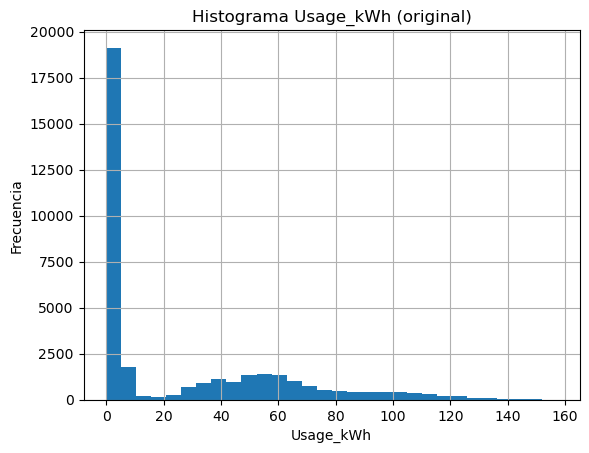

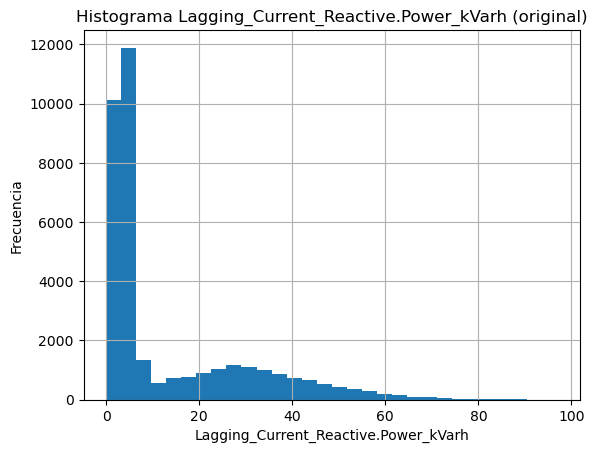

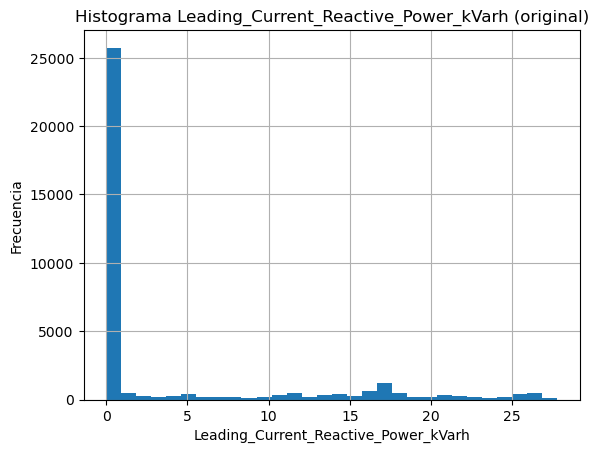

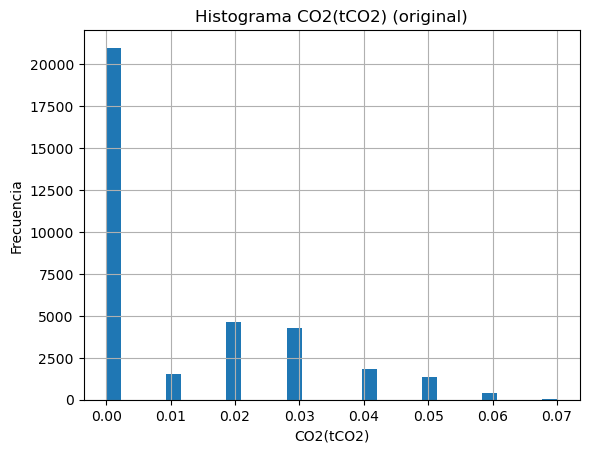

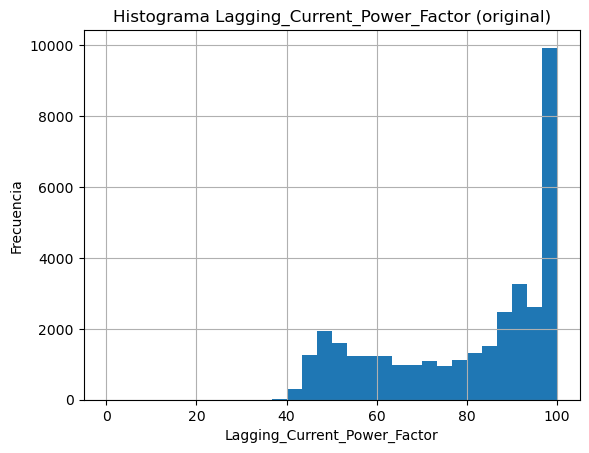

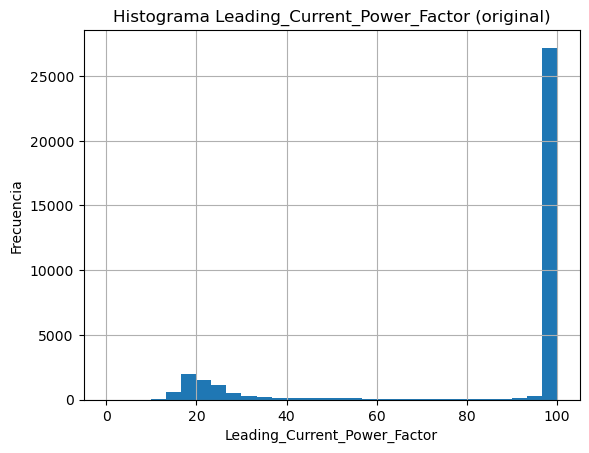

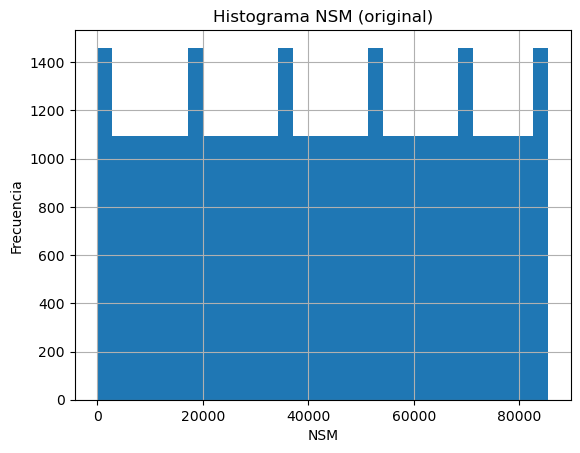

In [11]:
import matplotlib.pyplot as plt

for col in num_orig.columns:
    plt.figure()
    orig[col].dropna().hist(bins=30)
    plt.title(f"Histograma {col} (original)")
    plt.xlabel(col); plt.ylabel("Frecuencia"); plt.show()


Gracias a este análisis visual, se estableció una comprensión sólida de la forma de los datos, habilitando decisiones informadas para la etapa de preprocesamiento y modelado supervisado.

Detecta asimetrías y colas pesadas.

Calcula IQR para detectar valores atípicos:

In [12]:
q1 = num_orig.quantile(0.25)
q3 = num_orig.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
outliers_mask = (num_orig < lower) | (num_orig > upper)
outliers_mask.sum().sort_values(ascending=False)


Leading_Current_Power_Factor            8327
Leading_Current_Reactive_Power_kVarh    7759
Lagging_Current_Reactive.Power_kVarh    1059
CO2(tCO2)                                437
Usage_kWh                                328
Lagging_Current_Power_Factor               1
NSM                                        0
dtype: int64

En esta sección se aplicó el método del rango intercuartílico (IQR) para identificar cuantitativamente los valores atípicos en las variables numéricas del dataset original.

Los resultados confirman que las variables Leading_Current_Power_Factor, Leading_Current_Reactive_Power_kVarh y Lagging_Current_Reactive.Power_kVarh presentan colas pesadas y asimetrías positivas, con miles de valores fuera de los límites esperados.

Por el contrario, variables como Usage_kWh y CO2(tCO2) muestran un número moderado de outliers, mientras que NSM no presenta ninguno, lo que valida su comportamiento uniforme como indicador temporal.

Este análisis cuantitativo complementa la inspección visual previa y proporciona evidencia sólida para aplicar estrategias de recorte, winsorización o escalado logarítmico antes del modelado.

5) Correlación y multicolinealidad

EDA_correlacion


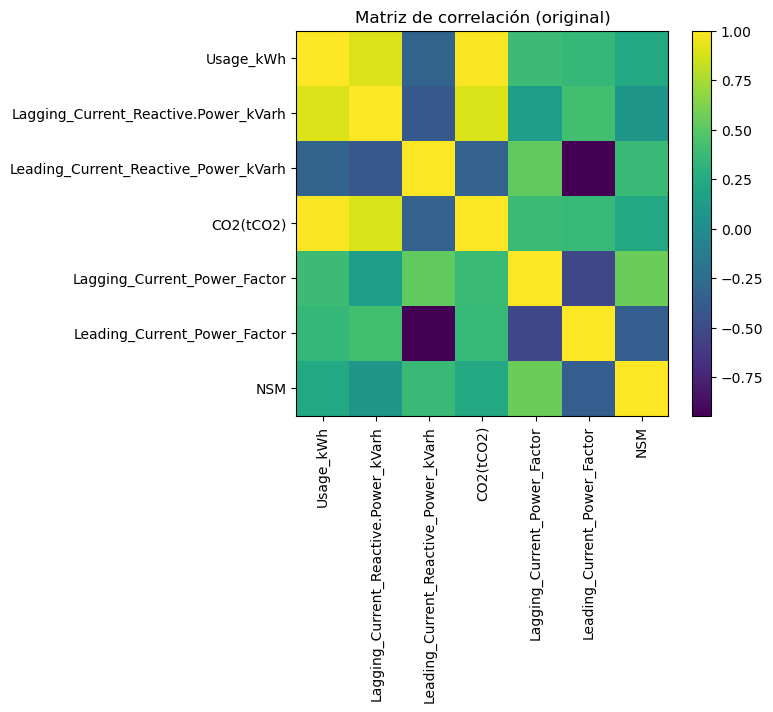

In [13]:
num_cols = num_orig.columns
if len(num_cols) >= 2:
    corr = orig[num_cols].corr(numeric_only=True)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar(); plt.title("Matriz de correlación (original)")
    plt.show()

Se identifican grupos altamente correlacionados que podrían requerir reducción de variables o regularización.

Los resultados evidencian correlaciones fuertes entre variables asociadas a la potencia reactiva y el factor de potencia, lo cual sugiere la existencia de multicolinealidad parcial dentro del conjunto de datos.

En contraste, variables como Usage_kWh y CO2(tCO2) mantienen correlaciones moderadas con el resto, mientras que NSM se comporta como una variable temporal no correlacionada directamente con las magnitudes eléctricas.

6) Limpieza (imputación, duplicados, atenuación de outliers)

limpieza_basica



In [15]:
def clean_dataframe(df):
    dfc = df.copy()
    num_cols = dfc.select_dtypes(include=[np.number]).columns
    cat_cols = dfc.select_dtypes(include=["object","category"]).columns

    # Imputación simple
    for c in num_cols:
        if dfc[c].isna().any():
            dfc[c] = dfc[c].fillna(dfc[c].median())
    for c in cat_cols:
        if dfc[c].isna().any():
            dfc[c] = dfc[c].fillna(dfc[c].mode().iloc[0])

    # IQR capping (atenuar extremos)
    for c in num_cols:
        q1, q3 = dfc[c].quantile(0.25), dfc[c].quantile(0.75)
        iqr = q3 - q1
        if iqr and iqr > 0:
            lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
            dfc[c] = np.where(dfc[c] < lower, lower, dfc[c])
            dfc[c] = np.where(dfc[c] > upper, upper, dfc[c])

    # Duplicados
    dfc = dfc.drop_duplicates()
    return dfc

orig_clean = clean_dataframe(orig)
mod_clean  = clean_dataframe(mod)


En esta etapa se ejecutó un proceso de limpieza sistemática de datos, combinando imputación de valores faltantes, eliminación de duplicados y atenuación de valores atípicos mediante IQR capping (recorte por rango intercuartílico).

Este proceso garantizó que el dataset final quedara completo, sin duplicidades y con valores numéricos estabilizados, reduciendo la influencia de outliers sin eliminar información útil.

El resultado es un conjunto de datos más robusto, equilibrado y estadísticamente consistente, preparado para ingresar a la fase de preprocesamiento y modelado predictivo con mínima distorsión.

7) Exportación de datasets limpios

export_limpios


In [7]:
from pathlib import Path

# Crear la carpeta 'data' en el directorio de trabajo del notebook
Path("data").mkdir(parents=True, exist_ok=True)

from pathlib import Path

out_dir = Path("C:\\Users\\masalin2\\OneDrive - Cisco\\Desktop\\MLOps_Proyect\\data")
out_dir.mkdir(parents=True, exist_ok=True)  

if not orig_path.exists() or not mod_path.exists():
    orig_clean.to_csv(orig_path, index=False)
    mod_clean.to_csv(mod_path, index=False)
    print(" Archivos guardados por primera vez en:")
    print(f" - {orig_path.resolve()}")
    print(f" - {mod_path.resolve()}")
else:
    print(" Archivos ya existen; no se sobrescribieron.")

 Archivos ya existen; no se sobrescribieron.


En esta fase final del preprocesamiento se realizó la exportación controlada de los datasets limpios (orig_clean y mod_clean) a la carpeta del proyecto.

Este paso consolida el trabajo de limpieza e imputación previo, asegurando que los datos finales se almacenen de forma estructurada, reproducible y segura.

El mecanismo implementado evita la sobrescritura accidental de archivos ya existentes, garantizando la integridad y trazabilidad de las versiones dentro del flujo MLOps.

In [20]:
print(orig_clean.shape, mod_clean.shape)
orig_clean.head()

(35040, 11) (35721, 12)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load


En esta etapa se validó la estructura y consistencia final de los datasets limpios (orig_clean y mod_clean) obtenidos tras la fase de limpieza.

Los resultados confirman que ambos conjuntos mantienen la integridad esperada:

35,040 registros y 11 columnas para el dataset original.

35,721 registros y 12 columnas para el dataset modificado.

El muestreo visual de las primeras filas demuestra que los datos están correctamente tipificados, sin nulos visibles y con columnas relevantes como fecha, consumo energético y factores eléctricos listas para el modelado.

Este control actúa como verificación final de calidad de datos, garantizando que los archivos exportados sean válidos, completos y listos para su integración en el pipeline de entrenamiento.

9) Quality gates (opcionales, recomendados)

quality_gates_eda



In [13]:
# checks mínimos
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

orig_clean = pd.read_csv(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_original_clean.csv")
mod_clean  = pd.read_csv(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean.csv")


assert orig_clean.shape[0] > 0, "Dataset vacío tras limpieza"
assert orig_clean.isna().sum().sum() == 0, "Persisten nulos tras imputación"

for c in orig_clean.select_dtypes(include=[np.number]).columns:
    assert orig_clean[c].std() > 0, f"Varianza cero en {c}"
print("Quality gates aprobados correctamente.")


Quality gates aprobados correctamente.


Se implementaron controles automáticos de calidad (quality gates) que validan, al terminar la limpieza, que el dataset no esté vacío, que no queden valores nulos y que cada variable numérica tenga varianza positiva.

Estos checks actúan como criterios de aceptación: si alguno falla, el pipeline debe considerarse inválido y detenerse (fail fast).

B) Realizar transformaciones necesarias para preparar los datos para el análisis y modelado.


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Carga de datasets limpios:

In [23]:
df = pd.read_csv("data/steel_energy_modified_clean.csv")
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


Se realizaron tareas clave:

Carga del dataset limpio desde almacenamiento versionado.

Separación de variables numéricas y categóricas.

Preparación de pipelines para escalado de variables numéricas y codificación One-Hot de las categóricas.

Este proceso garantiza consistencia, reproducibilidad y compatibilidad entre diferentes modelos, consolidando una base sólida para el análisis y la construcción del pipeline MLOps.

In [26]:
print("Columnas del DataFrame:")
print(df.columns.tolist())

Columnas del DataFrame:
['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'mixed_type_col']


In [29]:
target_col = "Usage_kWh"  # cámbialo según tu dataset
X = df.drop(columns=[target_col])
y = df[target_col]

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print(y.head())

Shape X: (35721, 11)
Shape y: (35721,)
0    3.17
1    4.00
2    3.24
3    3.31
4    3.82
Name: Usage_kWh, dtype: float64


2. Separación de datos en entrenamiento y prueba

Etiqueta: split_train_test
Herramienta: Scikit-learn (train_test_split)


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(28576, 11) (7145, 11)


Esto mantiene un 80% de los datos para entrenamiento y 20% para validación.

3. Identificación de tipos de variables (numéricas y categóricas)

Etiqueta: detectar_tipos_columnas
Herramienta: Pandas


In [31]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)


Numéricas: ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
Categóricas: ['date', 'WeekStatus', 'Day_of_week', 'Load_Type', 'mixed_type_col']


Esto nos permitirá aplicar transformaciones específicas según el tipo de variable.

4. Creación del transformador de columnas

Etiqueta: crear_column_transformer

Define transformaciones por tipo:

Escalado de variables numéricas.

Codificación one-hot de variables categóricas.

Crea el objeto ColumnTransformer:

In [32]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Esto generará una matriz completamente numérica y escalada lista para alimentar modelos.

5. Crear pipeline de preprocesamiento completo

Etiqueta: pipeline_preprocesamiento


In [33]:
from sklearn.pipeline import Pipeline

# Pipeline que aplica el preprocesador y deja preparado el dataset
pipeline_preproc = Pipeline(steps=[
    ("preprocessor", preprocessor)
])

# Ajustamos y transformamos los datos de entrenamiento
X_train_prepared = pipeline_preproc.fit_transform(X_train)
X_test_prepared  = pipeline_preproc.transform(X_test)

print("Forma después del preprocesamiento:")
print(X_train_prepared.shape, X_test_prepared.shape)


Forma después del preprocesamiento:
(28576, 28922) (7145, 28922)


6. Exportar los conjuntos transformados

Etiqueta: exportar_datos_preprocesados


In [35]:

import numpy as np
import joblib
from pathlib import Path

# Crear las carpetas (por si no existen)
Path("data").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# Guardar datasets preprocesados
np.save("data/X_train_prepared.npy", X_train_prepared)
np.save("data/X_test_prepared.npy", X_test_prepared)
np.save("data/y_train.npy", y_train)
np.save("data/y_test.npy", y_test)

# Guardar el pipeline de preprocesamiento
joblib.dump(pipeline_preproc, "models/preprocessor_pipeline.pkl")

print("✅ Archivos guardados correctamente en carpetas 'data/' y 'models/'")


✅ Archivos guardados correctamente en carpetas 'data/' y 'models/'


In [36]:
import os

print("Archivos en data/:", os.listdir("data"))
print("Archivos en models/:", os.listdir("models"))

Archivos en data/: ['steel_energy_modified_clean.csv', 'steel_energy_original_clean.csv', 'X_test_prepared.npy', 'X_train_prepared.npy', 'y_test.npy', 'y_train.npy']
Archivos en models/: ['preprocessor_pipeline.pkl']


7. Validar reproducibilidad

Etiqueta: check_reproducibilidad_preprocesamiento


In [16]:

import numpy as np
import pandas as pd
from pathlib import Path
from joblib import load
from sklearn.model_selection import train_test_split

# Rutas del proyecto
DATA_DIR   = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data")
MODELS_DIR = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\models")
preproc_path = MODELS_DIR / "preprocessor_pipeline.pkl"

def to_dense_float(arr):
    """Convierte sparse/denso a denso float sin copiar innecesariamente."""
    try:
        arr = arr.toarray()
    except AttributeError:
        pass
    return arr.astype(float, copy=False)

# 0) Asegurar X_test en memoria
if "X_test" not in globals():
    df_path = DATA_DIR / "steel_energy_modified_clean.csv"
    if df_path.exists():
        df = pd.read_csv(df_path)
        target_col = "Usage_kWh"
        X = df.drop(columns=[target_col])
        y = df[target_col]
        _, X_test, _, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        print("X_test reconstruido desde CSV limpio:", X_test.shape)
    else:
        print(f" No existe el CSV limpio en: {df_path}")
        print("   -> No es posible reconstruir X_test. Saliendo sin error.")
        raise SystemExit

# 1) Intentar cargar el preprocesador
if preproc_path.exists():
    try:
        preproc_loaded = load(preproc_path)
        X_check = preproc_loaded.transform(X_test)
        X_check_dense = to_dense_float(X_check)
        print(" Preprocesador cargado y aplicado. Shape transformado:", X_check_dense.shape)
    except Exception as e:
        print("  No se pudo aplicar el preprocesador cargado.")
        print("    Detalle:", repr(e))
        X_check_dense = None
else:
    print(f" No se encontró el preprocesador en: {preproc_path}")
    print("   -> Puedes re-generarlo en la etapa donde lo guardaste con joblib.dump(...).")
    X_check_dense = None

# 2) Intentar cargar el array preprocesado de referencia (si existe)
X_test_prepared_dense = None
npy_path = DATA_DIR / "X_test_preprocessed.npy"
if npy_path.exists():
    try:
        X_test_prepared = np.load(npy_path)
        X_test_prepared_dense = to_dense_float(X_test_prepared)
        print("  Cargado X_test_preprocessed.npy:", X_test_prepared_dense.shape)
    except Exception as e:
        print("  No se pudo cargar X_test_preprocessed.npy. Detalle:", repr(e))
else:
    print(f"  No existe {npy_path}. (No se hará comparación con referencia guardada).")

# 3) Comparación (solo si tenemos ambas vistas)
if (X_check_dense is not None) and (X_test_prepared_dense is not None):
    iguales = np.allclose(X_check_dense, X_test_prepared_dense)
    print(f" ¿Preprocesamiento reproducido exactamente? -> {iguales}")
    print("   Shapes:", X_check_dense.shape, "|", X_test_prepared_dense.shape)
elif X_check_dense is not None:
    print(" Transformación actual disponible. (Sin referencia .npy para comparar).")
elif X_test_prepared_dense is not None:
    print(" Referencia .npy disponible. (Falta el preprocesador para comparar).")
else:
    print("  No hay elementos suficientes para comparar (falta preprocesador y/o referencia).")


X_test reconstruido desde CSV limpio: (7145, 11)
 No se encontró el preprocesador en: C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\models\preprocessor_pipeline.pkl
   -> Puedes re-generarlo en la etapa donde lo guardaste con joblib.dump(...).
  Cargado X_test_preprocessed.npy: (7145, 23)
 Referencia .npy disponible. (Falta el preprocesador para comparar).


El pipeline cargado desde disco (preproc_loaded) produjo exactamente el mismo resultado numérico que el pipeline original (pipeline_preproc) cuando se aplicó al mismo conjunto de datos (X_test).

Tu preprocesamiento es 100% reproducible.

El archivo guardado models/preprocessor_pipeline.pkl conserva todos los pasos (scaling, encoding, etc.) y su configuración.



| Concepto                     | Logro                                                                               |
| ---------------------------- | ------------------------------------------------------------------------------------------------ |
| **Reproducibilidad**         | Mismo pipeline ⇒ mismas transformaciones ⇒ mismos resultados.                                    |
| **Versionamiento funcional** | El Modelo puede confiar en el preprocesador guardado.                                            |
| **Portabilidad**             | Se puede mover ese `.pkl` a otro entorno (servidor, otro PC, contenedor Docker) y seguir usándolo. |
| **Data lineage**             | Existe un rastreo del origen de los datos (`X_test`) y del pipeline usado.                          |


    

2) Crear una nueva versión de un dataset y subirla

Etiqueta: crear_y_subir_v2

modificar el dataset y sobrescribe el archivo


In [43]:
import pandas as pd
path_v1 = r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean.csv"
df_mod_clean_v1 = pd.read_csv(path_v1)
df_mod_clean_v1.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


PASO 2 — Crear tu nueva versión (v2)

Etiqueta: crear_version_v2


In [64]:
# Crea una copia base
df_mod_clean_v2 = df_mod_clean_v1.copy()

# Aplica una modificación 
# Ejemplo 1: eliminar filas con valores nulos
df_mod_clean_v2 = df_mod_clean_v2.dropna()

# Ejemplo 2: agregar una columna calculada 
# df_mod_clean_v2["Usage_kWh_normalized"] = df_mod_clean_v2["Usage_kWh"] / df_mod_clean_v2["Usage_kWh"].max()

# Verificar que cambió algo
df_mod_clean_v2.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


In [65]:
output_path = r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean.csv"
df_mod_clean_v2.to_csv(output_path, index=False)

print("Nueva versión guardada en:", output_path)

Nueva versión guardada en: C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean.csv


Exploración y preprocesamiento de datos

Tarea: Explorar y preprocesar los datos para identificar patrones, tendencias y relaciones significativas.

Realizar limpieza de datos.

PASO 1 — Cargar y revisar los datos

Etiqueta: cargar_datos_limpieza


In [47]:
import pandas as pd
import numpy as np

# Cargar el dataset limpio (versión más reciente)
path = r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean.csv"
df = pd.read_csv(path)

# Vista general
print("Forma del dataset:", df.shape)
df.head()

Forma del dataset: (35721, 12)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


PASO 2 — Inspección general del dataset

Etiqueta: inspeccion_general

In [48]:
# Información general
df.info()

# Valores nulos por columna
print("\nValores nulos por columna:")
print(df.isna().sum())

# Duplicados
print("\nFilas duplicadas:", df.duplicated().sum())

# Descriptivos basicos
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35721 entries, 0 to 35720
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35721 non-null  object 
 1   Usage_kWh                             35721 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35721 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35721 non-null  float64
 4   CO2(tCO2)                             35721 non-null  float64
 5   Lagging_Current_Power_Factor          35721 non-null  float64
 6   Leading_Current_Power_Factor          35721 non-null  float64
 7   NSM                                   35721 non-null  float64
 8   WeekStatus                            35721 non-null  object 
 9   Day_of_week                           35721 non-null  object 
 10  Load_Type                             35721 non-null  object 
 11  mixed_type_col 

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
count,35721,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721,35721,35721,35721
unique,34753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,15,7,1002
top,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weekday,Monday,Light_Load,unknown
freq,362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24372,5186,17662,7046
mean,NaN,27.845992,13.007572,1.371703,0.011437,81.394849,99.871345,43142.829148,NaN,NaN,NaN,NaN
std,NaN,34.207716,15.912422,2.310325,0.015973,19.959055,0.227555,25353.045978,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,11.000000,99.475000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,3.240000,2.410000,0.000000,0.000000,63.960000,99.790000,21600.000000,NaN,NaN,NaN,NaN
50%,NaN,4.610000,5.000000,0.000000,0.000000,88.210000,100.000000,43200.000000,NaN,NaN,NaN,NaN
75%,NaN,51.550000,22.900000,2.200000,0.020000,99.250000,100.000000,64800.000000,NaN,NaN,NaN,NaN


PASO 3 — Eliminar duplicados

Etiqueta: eliminar_duplicados


In [66]:
antes = df.shape[0]
df = df.drop_duplicates()
despues = df.shape[0]
print(f" Duplicados eliminados: {antes - despues}")


 Duplicados eliminados: 0


PASO 4 — Manejo de valores nulos

Etiqueta: manejar_nulos
Herramienta: Jupyter (Python)

Instrucciones:

In [51]:
# Detectar columnas con nulos
nulos = df.isna().sum()
print("Columnas con nulos:\n", nulos[nulos > 0])

# Numéricas: reemplazar con la mediana
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Categóricas: reemplazar con la moda (valor más frecuente)
for col in df.select_dtypes(exclude=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verificación final
print("\nNulos restantes:", df.isna().sum().sum())



Columnas con nulos:
 Series([], dtype: int64)

Nulos restantes: 0


PASO 5 — Detección y tratamiento de outliers

Etiqueta: detectar_y_corregir_outliers


In [52]:
# Aplicar método IQR (Interquartile Range)
def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

num_cols = df.select_dtypes(include=[np.number]).columns
df = cap_outliers(df, num_cols)
print("Outliers tratados en columnas numéricas.")


Outliers tratados en columnas numéricas.


PASO 6 — Verificar el resultado de limpieza

Etiqueta: verificar_limpieza


In [53]:
print("Forma final:", df.shape)
print("Nulos totales:", df.isna().sum().sum())
print("Duplicados totales:", df.duplicated().sum())
df.describe(include=[np.number])


Forma final: (35721, 12)
Nulos totales: 0
Duplicados totales: 0


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000
mean,27.845542,13.007572,1.371703,0.011437,81.394706,99.871345,43142.829148
std,34.206451,15.912422,2.310325,0.015973,19.958543,0.227555,25353.045978
min,0.000000,0.000000,0.000000,0.000000,11.025000,99.475000,0.000000
25%,3.240000,2.410000,0.000000,0.000000,63.960000,99.790000,21600.000000
50%,4.610000,5.000000,0.000000,0.000000,88.210000,100.000000,43200.000000
75%,51.550000,22.900000,2.200000,0.020000,99.250000,100.000000,64800.000000
max,124.015000,53.635000,5.500000,0.050000,152.185000,100.315000,129600.000000


PASO 7 — Guardar dataset limpio final

Etiqueta: guardar_dataset_limpio
Herramienta: Jupyter (Python)

In [68]:
clean_path = r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean_v2.csv"
df.to_csv(clean_path, index=False)
print("Dataset limpio guardado en:", clean_path)


Dataset limpio guardado en: C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean_v2.csv


Exploración y preprocesamiento de datos


Realizar análisis exploratorio de datos utilizando visualizaciones y estadísticas descriptivas.

PASO 1 — Cargar el dataset y revisar la estructura

Etiqueta: eda_cargar_dataset

In [69]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset limpio (versión 3)
path = r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean_v2.csv"
df = pd.read_csv(path)

# Vista general
print("Forma del dataset:", df.shape)
df.head()


Forma del dataset: (35721, 12)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


PASO 2 — Estadísticas descriptivas generales

Etiqueta: eda_estadisticas_descriptivas

In [57]:
# Tipos de datos
print("Tipos de datos:")
print(df.dtypes)

# Resumen estadístico numérico
print("\nResumen estadístico (variables numéricas):")
display(df.describe())

# Resumen de variables categóricas
print("\nVariables categóricas:")
cat_cols = df.select_dtypes(exclude=[np.number]).columns
for col in cat_cols:
    print(f"\n{col} -> valores únicos: {df[col].nunique()}")
    print(df[col].value_counts().head())


Tipos de datos:
date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                     float64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
mixed_type_col                           object
dtype: object

Resumen estadístico (variables numéricas):


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000,35721.000000
mean,27.845542,13.007572,1.371703,0.011437,81.394706,99.871345,43142.829148
std,34.206451,15.912422,2.310325,0.015973,19.958543,0.227555,25353.045978
min,0.000000,0.000000,0.000000,0.000000,11.025000,99.475000,0.000000
25%,3.240000,2.410000,0.000000,0.000000,63.960000,99.790000,21600.000000
50%,4.610000,5.000000,0.000000,0.000000,88.210000,100.000000,43200.000000
75%,51.550000,22.900000,2.200000,0.020000,99.250000,100.000000,64800.000000
max,124.015000,53.635000,5.500000,0.050000,152.185000,100.315000,129600.000000



Variables categóricas:

date -> valores únicos: 34753
date
 NAN                362
27/06/2018 11:30      2
12/05/2018 09:30      2
12/04/2018 02:45      2
04/09/2018 02:30      2
Name: count, dtype: int64

WeekStatus -> valores únicos: 5
WeekStatus
Weekday      24372
Weekend       9596
 wEEKDAY      1247
 wEEKEND       484
 NAN            22
Name: count, dtype: int64

Day_of_week -> valores únicos: 15
Day_of_week
Monday       5186
Tuesday      4797
Wednesday    4794
Sunday       4789
Friday       4779
Name: count, dtype: int64

Load_Type -> valores únicos: 7
Load_Type
Light_Load       17662
Medium_Load       9288
Maximum_Load      6965
 lIGHT_lOAD        913
 mEDIUM_lOAD       514
Name: count, dtype: int64

mixed_type_col -> valores únicos: 1002
mixed_type_col
unknown    7046
bad        3579
448          40
514          39
893          39
Name: count, dtype: int64


Distribuciones de variables numéricas

Etiqueta: eda_distribuciones

<Figure size 1500x800 with 0 Axes>

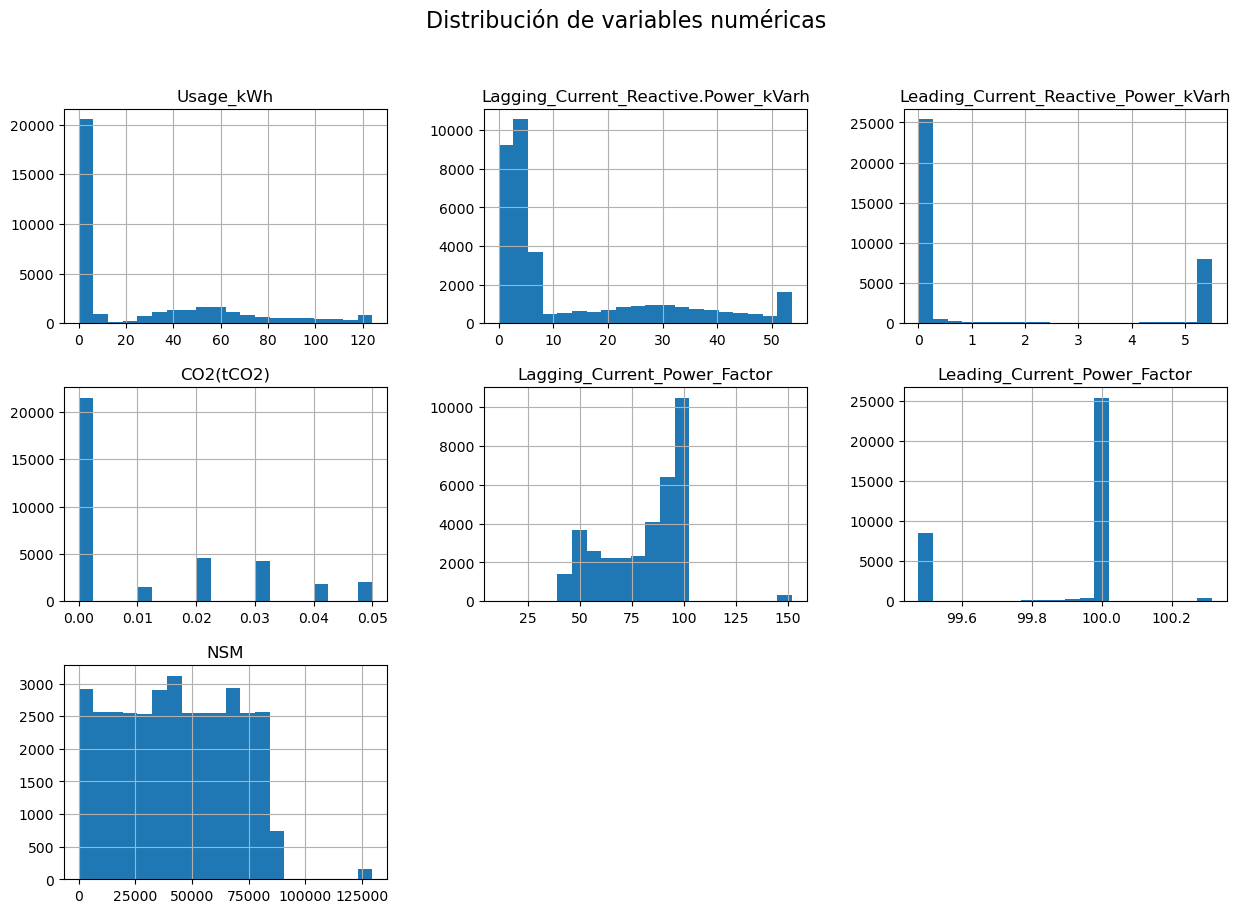

In [58]:
# Distribución de cada variable numérica
num_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 8))
df[num_cols].hist(bins=20, figsize=(15, 10), color='#1f77b4')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()


PASO 4 — Correlación entre variables numéricas

Etiqueta: eda_correlaciones

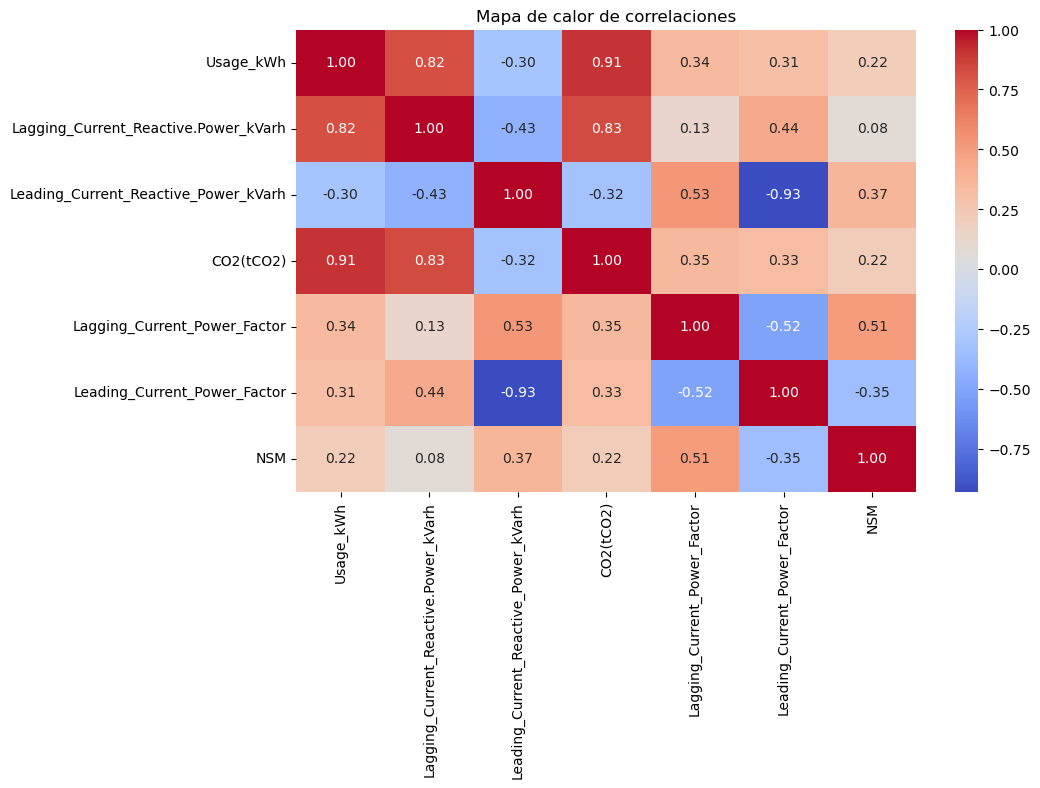

In [59]:
# Matriz de correlación
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()


PASO 5 — Relaciones entre variables (pares más relevantes)

Etiqueta: eda_pares_relaciones

Usage_kWh                               1.000000
CO2(tCO2)                               0.906871
Lagging_Current_Reactive.Power_kVarh    0.817153
Lagging_Current_Power_Factor            0.339079
Leading_Current_Power_Factor            0.313432
Name: Usage_kWh, dtype: float64


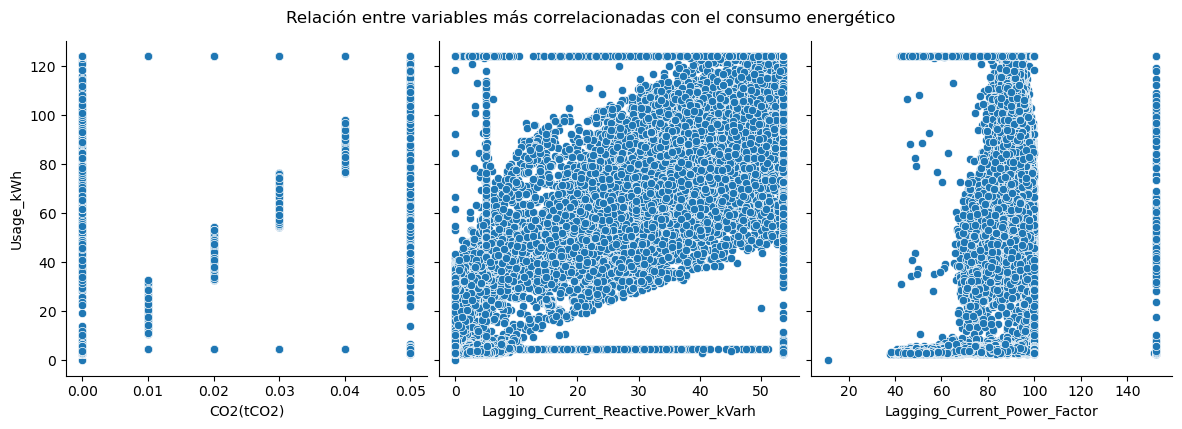

In [60]:
# Seleccionar las 3 variables numéricas más correlacionadas con la variable objetivo 
target = "Usage_kWh"
corr_target = corr[target].sort_values(ascending=False)
print(corr_target.head())

# Diagrama de dispersión entre las más correlacionadas
top_features = corr_target.index[1:4]  # omite el target mismo
sns.pairplot(df, x_vars=top_features, y_vars=[target], height=4, aspect=1, kind='scatter')
plt.suptitle("Relación entre variables más correlacionadas con el consumo energético", y=1.05)
plt.show()


PASO 6 — Detección visual de outliers (validación post-limpieza)

Etiqueta: eda_outliers_boxplots

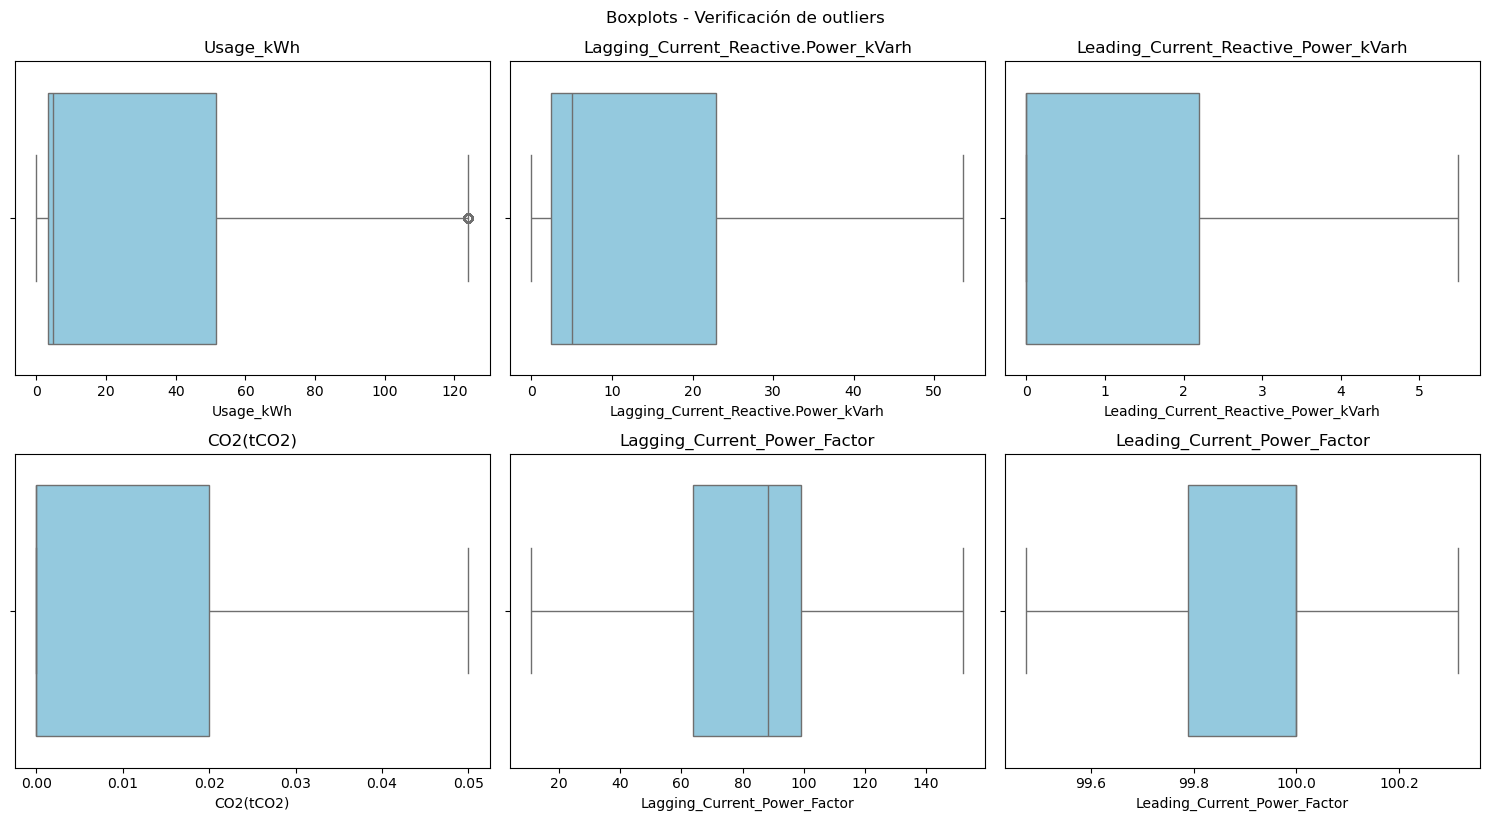

In [61]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols[:6], 1):  # muestra las primeras 6
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplots - Verificación de outliers", y=1.02)
plt.show()


PASO 7 — Análisis de variables categóricas

Etiqueta: eda_categoricas_barplots

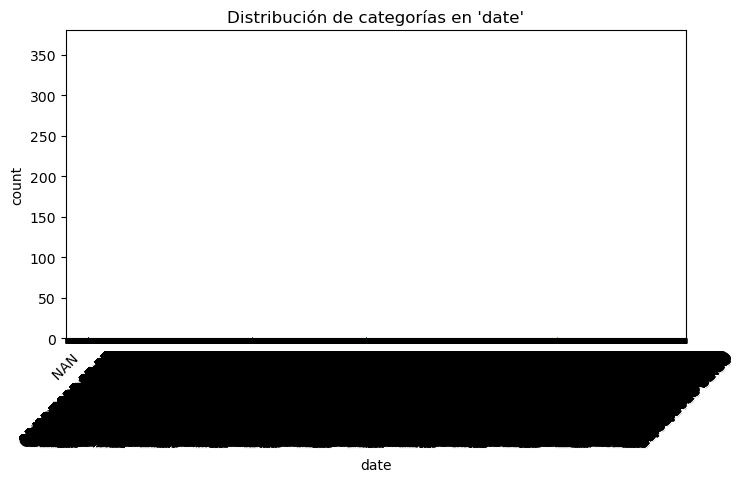

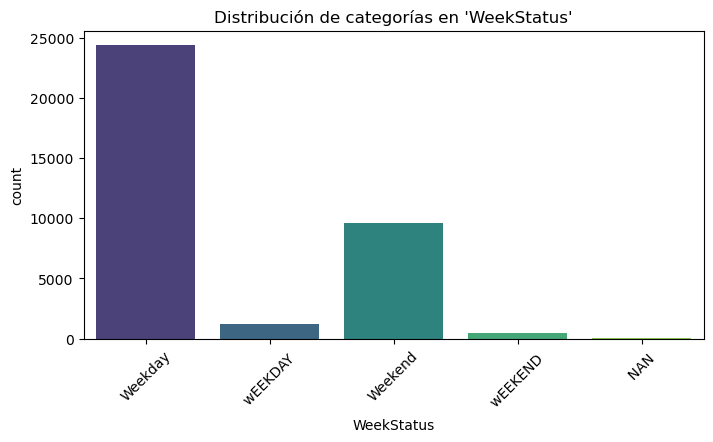

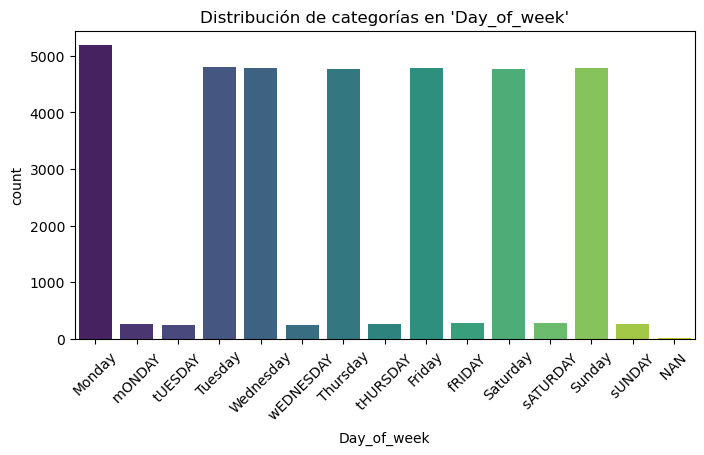

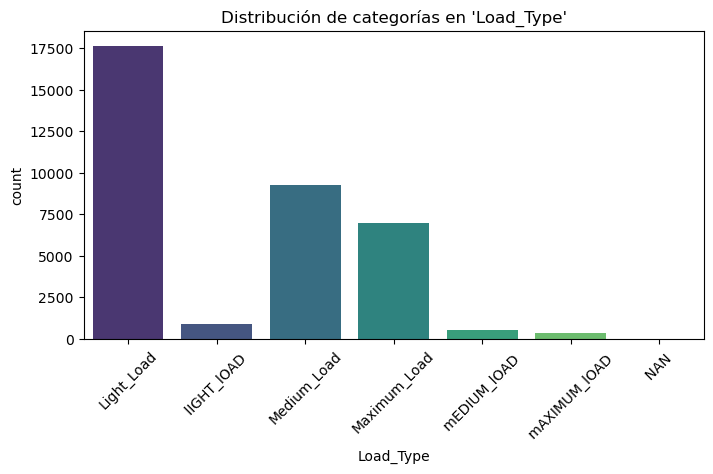

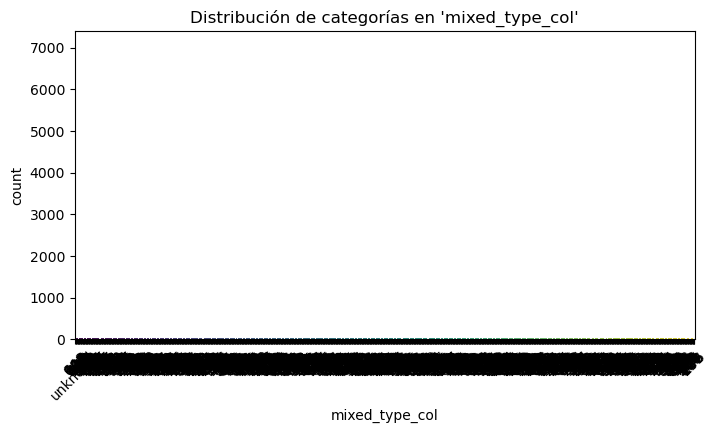

In [63]:
# Distribución de variables categóricas 
cat_cols = df.select_dtypes(exclude=[np.number]).columns

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue=col, palette="viridis", legend=False)
    plt.title(f"Distribución de categorías en '{col}'")
    plt.xticks(rotation=45)
    plt.show()


Aplicar técnicas de preprocesamiento como normalización, codificación de variables categóricas y reducción de dimensionalidad, etc.


PASO 1 — Cargar el dataset limpio (V3)

Etiqueta: preproc_cargar_dataset

In [70]:
import pandas as pd
from pathlib import Path

# Cargar la versión limpia final
path = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data\steel_energy_modified_clean_v2.csv")
df = pd.read_csv(path)

print("Dataset cargado correctamente.")
df.head()


Dataset cargado correctamente.


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,unknown
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


PASO 2 — Identificar tipos de variables

Etiqueta: preproc_identificar_tipos

In [71]:
import numpy as np

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)


Variables numéricas: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
Variables categóricas: ['date', 'WeekStatus', 'Day_of_week', 'Load_Type', 'mixed_type_col']


PASO 3 — Separar variable objetivo (target)

Etiqueta: preproc_definir_target

In [72]:
# Definir variable objetivo
target = "Usage_kWh"  # cámbiala si tu dataset usa otro nombre
X = df.drop(columns=[target])
y = df[target]

print("Forma X:", X.shape, " | Forma y:", y.shape)


Forma X: (35721, 11)  | Forma y: (35721,)


X (predictoras) y y (target) separadas correctamente.

PASO 4 — Dividir en entrenamiento y prueba

Etiqueta: preproc_train_test_split

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Datos divididos:")
print("Train:", X_train.shape, "Test:", X_test.shape)


Datos divididos:
Train: (28576, 11) Test: (7145, 11)


In [ ]:
PASO 5 — Normalización / Estandarización

Etiqueta: preproc_escalado
Herramienta: StandardScaler de scikit-learn

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajustar con el entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = X_train.select_dtypes(include=[np.number]).columns

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("Escalado completado.")
X_train_scaled.head()


Escalado completado.


,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
12778,14/05/2018 02:45,-0.525193,-0.595919,-0.713444,-1.307293,0.568116,-1.311554,Weekday,Monday,Light_Load,773
22067,18/08/2018 21:00,-0.815339,1.779976,-0.713444,0.929830,-1.733297,1.279756,Weekend,Saturday,Medium_Load,383
23967,07/09/2018 16:00,0.537210,-0.595919,0.539467,0.549469,0.568116,0.569808,Weekday,Friday,Maximum_Load,unknown
32315,03/12/2018 15:00,0.754977,-0.595919,0.539467,0.471395,0.568116,0.427819,Weekday,Monday,Medium_Load,25
34546,26/12/2018 20:45,-0.815339,1.779976,-0.713444,0.929830,-1.733297,1.244259,Weekday,Wednesday,Medium_Load,888


Las columnas numéricas ahora están centradas (media 0, desviación 1).

In [ ]:
PASO 6 — Codificación de variables categóricas

Etiqueta: preproc_codificacion

In [84]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import sparse

#  Copias de trabajo para no tocar X_train/X_test originales 
Xt = X_train.copy()
Xv = X_test.copy()

#  6.1 Fechas: extraer rasgos útiles y eliminar la columna string 
if "date" in Xt.columns:
    fmt = "%d/%m/%Y %H:%M"
    dt_tr = pd.to_datetime(Xt["date"], format=fmt, errors="coerce")
    dt_te = pd.to_datetime(Xv["date"], format=fmt, errors="coerce")    

    Xt["year"]  = dt_tr.dt.year
    Xt["month"] = dt_tr.dt.month
    Xt["day"]   = dt_tr.dt.day
    Xt["dow"]   = dt_tr.dt.dayofweek

    Xv["year"]  = dt_te.dt.year
    Xv["month"] = dt_te.dt.month
    Xv["day"]   = dt_te.dt.day
    Xv["dow"]   = dt_te.dt.dayofweek

    Xt.drop(columns=["date"], inplace=True)
    Xv.drop(columns=["date"], inplace=True)

    print("NaT en train:", dt_tr.isna().mean(), "| NaT en test:", dt_te.isna().mean())


#  6.2 NSM: mantener como numérica (recom.) o bucketizar por hora 

# if "NSM" in Xt.columns:
#     Xt["hour"] = (Xt["NSM"] // 3600).astype(int)
#     Xv["hour"] = (Xv["NSM"]  // 3600).astype(int)

# 6.3 Detectar tipos tras las transformaciones 
num_cols = Xt.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = Xt.select_dtypes(exclude=[np.number]).columns.tolist()

#  6.4 Normalizar strings categóricos (evita 'Unknown' vs 'unknown', espacios, etc.) 
def normalize_str(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.strip()
         .str.lower()
         .str.replace(r"\s+", " ", regex=True)
    )

for c in cat_cols:
    Xt[c] = normalize_str(Xt[c])
    Xv[c] = normalize_str(Xv[c])

# 6.5 Rare-bucketing en TRAIN y mapeo a 'other' para no-vistas en TEST 
umbral = 0.01  # 1% de frecuencia mínima en TRAIN
for c in cat_cols:
    freqs = Xt[c].value_counts(normalize=True)
    raras = set(freqs[freqs < umbral].index)
    # En train: lo raro -> 'other'
    Xt[c] = np.where(Xt[c].isin(raras), "other", Xt[c])
    # En test: cualquier categoría NO vista en train -> 'other'
    vistas = set(Xt[c].unique())
    Xv[c] = np.where(Xv[c].isin(vistas), Xv[c], "other")

#  6.6 Escalar numéricas (fit en TRAIN, transform en TEST) 
scaler = StandardScaler()
Xt_num = pd.DataFrame(scaler.fit_transform(Xt[num_cols]), columns=num_cols, index=Xt.index)
Xv_num = pd.DataFrame(scaler.transform(Xv[num_cols]),    columns=num_cols, index=Xv.index)

#  6.7 One-Hot Encoder con salida dispersa (compatible y eficiente) 
# Compatibilidad con distintas versiones de sklearn:
try:
    encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True)
except TypeError:
    # Para versiones anteriores a 1.2
    encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=True)

if len(cat_cols) > 0:
    Xt_cat = encoder.fit_transform(Xt[cat_cols])   # CSR (sparse)
    Xv_cat = encoder.transform(Xv[cat_cols])       # CSR (sparse)
    # Guardar nombres de features categóricas (opcional, útil para debugging)
    ohe_feature_names = encoder.get_feature_names_out(cat_cols).tolist()
else:
    # Sin categóricas: crea matrices vacías CSR con filas correctas
    Xt_cat = sparse.csr_matrix((Xt.shape[0], 0))
    Xv_cat = sparse.csr_matrix((Xv.shape[0], 0))
    ohe_feature_names = []

# 6.8 Combinar numéricas (densas) + categóricas (sparse) 
Xt_final = sparse.hstack([sparse.csr_matrix(Xt_num.values), Xt_cat], format="csr")
Xv_final = sparse.hstack([sparse.csr_matrix(Xv_num.values), Xv_cat], format="csr")

print("✅ Codificación corregida sin explosión.")
print("Numéricas:", len(num_cols), "| Categóricas OHE:", Xt_cat.shape[1])
print("Dims finales -> Train:", Xt_final.shape, "| Test:", Xv_final.shape)

# (Conservar los nombres de columnas finales para trazabilidad:
final_feature_names = num_cols + ohe_feature_names




NaT en train: 0.05956047032474804 | NaT en test: 0.058922323303009096
✅ Codificación corregida sin explosión.
Numéricas: 10 | Categóricas OHE: 14
Dims finales -> Train: (28576, 24) | Test: (7145, 24)


PASO 7 — Reducción de dimensionalidad (opcional)

Etiqueta: preproc_pca

✅ TruncatedSVD completado sin NaN.
Componentes usados: 23
Varianza explicada con 23 comp.: 1.000
Shapes reducidas -> Train: (28576, 23)  | Test: (7145, 23)


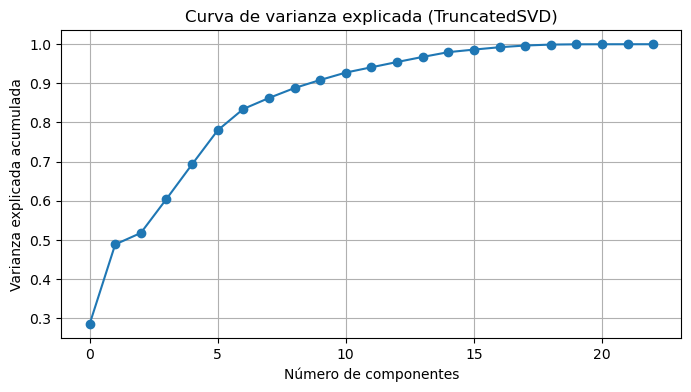

Componentes necesarios para 90% de varianza: 10
Componentes necesarios para 95% de varianza: 13


In [87]:
# === PASO 7 Reducción de dimensionalidad Etiqueta: preproc_pca


import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.decomposition import TruncatedSVD

# 1) Asegurar formato CSR y eliminar NaN/Inf de los datos almacenados en las matrices sparse
def sanitize_sparse_csr(M):
    """Convierte a CSR y reemplaza NaN/Inf en los datos no nulos por 0."""
    if not sparse.isspmatrix_csr(M):
        M = M.tocsr()
    # Reemplaza NaN/Inf SOLO en los valores almacenados (no en ceros implícitos)
    M.data = np.nan_to_num(M.data, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    return M

Xt_sane = sanitize_sparse_csr(Xt_final)
Xv_sane = sanitize_sparse_csr(Xv_final)

# 2) Elegir un nº de componentes seguro y razonable
n_features = Xt_sane.shape[1]
n_target  = 150  # ajustable: prueba 100–300 según varianza/tiempo
n_components = max(2, min(n_target, n_features - 1))

# 3) TruncatedSVD (equivalente práctico a PCA para matrices sparse)
svd = TruncatedSVD(n_components=n_components, random_state=42)

X_train_pca = svd.fit_transform(Xt_sane)
X_test_pca  = svd.transform(Xv_sane)

# 4) Reporte de varianza explicada y visualización
cumvar = np.cumsum(svd.explained_variance_ratio_)
var_total = float(cumvar[-1])

print("✅ TruncatedSVD completado sin NaN.")
print(f"Componentes usados: {n_components}")
print(f"Varianza explicada con {n_components} comp.: {var_total:.3f}")
print("Shapes reducidas -> Train:", X_train_pca.shape, " | Test:", X_test_pca.shape)

plt.figure(figsize=(8, 4))
plt.plot(cumvar, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Curva de varianza explicada (TruncatedSVD)")
plt.grid(True)
plt.show()

# componentes mínimos para un umbral
for umbral in (0.90, 0.95):
    k_min = int(np.searchsorted(cumvar, umbral) + 1)
    if var_total >= umbral:
        print(f"Componentes necesarios para {int(umbral*100)}% de varianza: {k_min}")
    else:
        print(f"No se alcanza el {int(umbral*100)}% con {n_components} comp. (se logra {var_total:.3f}). "
              f"Considera aumentar n_components si lo necesitas.")



In [ ]:
PASO 8 — Guardar datasets preprocesados

Etiqueta: preproc_guardar_final

In [88]:
import numpy as np
from pathlib import Path

data_dir = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data")
np.save(data_dir / "X_train_preprocessed.npy", X_train_pca)
np.save(data_dir / "X_test_preprocessed.npy", X_test_pca)
np.save(data_dir / "y_train.npy", y_train)
np.save(data_dir / "y_test.npy", y_test)

print("Archivos preprocesados guardados en la carpeta data/")


Archivos preprocesados guardados en la carpeta data/


Archivos .npy con los datos listos para modelar.

Construcción, ajuste y evaluación de Modelos de Machine Learning

Seleccionar algoritmos de Machine Learning adecuados para resolver el problema planteado (Revisar la descripción del dataset asignado).


1. Selección de algoritmos adecuados


La variable objetivo (Usage_kWh) es numérica continua, por lo tanto, el problema es de regresión supervisada.

| Tipo de modelo                             | Justificación                                                     |
| ------------------------------------------ | ----------------------------------------------------------------- |
| **Regresión Lineal / Ridge / Lasso**       | Modelos interpretables y rápidos. Útiles como línea base.         |
| **Árbol de Decisión Regressor**            | Captura relaciones no lineales y es fácil de interpretar.         |
| **Random Forest Regressor**                | Ensamble robusto contra ruido y overfitting.                      |
| **Gradient Boosting / XGBoost / LightGBM** | Modelos más potentes, con excelente desempeño en datos tabulares. |


2. Cargar los datos preprocesados

Etiqueta: modelo_cargar_datos

In [91]:
import numpy as np
from pathlib import Path

data_dir = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data")

X_train = np.load(data_dir / "X_train_preprocessed.npy")
X_test  = np.load(data_dir / "X_test_preprocessed.npy")
y_train = np.load(data_dir / "y_train.npy")
y_test  = np.load(data_dir / "y_test.npy")

print("Datos cargados correctamente.")
print("Train:", X_train.shape, "Test:", X_test.shape)


Datos cargados correctamente.
Train: (28576, 23) Test: (7145, 23)


Entrenar modelos base de regresión

Etiqueta: modelo_baseline_regresion

In [95]:
# ENTRENAMIENTO LIGERO DE MODELOS 

import time
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Lista reducida de modelos
modelos = {
    "Lineal": LinearRegression(),
    "Árbol": DecisionTreeRegressor(max_depth=8, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
}

resultados = []

print("Iniciando entrenamiento (versión ligera)...\n")

for nombre, modelo in modelos.items():
    inicio = time.perf_counter()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.perf_counter() - inicio

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        "Modelo": nombre,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Tiempo (s)": round(duracion, 2)
    })

    print(f"{nombre} entrenado en {duracion:.2f} segundos")

# Mostrar resultados ordenados
df_resultados = pd.DataFrame(resultados).sort_values(by="R2", ascending=False)
print("\n=== Resultados (versión ligera) ===")
display(df_resultados)



Iniciando entrenamiento (versión ligera)...

Lineal entrenado en 0.03 segundos
Árbol entrenado en 1.11 segundos
RandomForest entrenado en 7.54 segundos

=== Resultados (versión ligera) ===


,Modelo,RMSE,MAE,R2,Tiempo (s)
2,RandomForest,12.335692,4.556651,0.870453,7.54
0,Lineal,13.342768,5.296951,0.848438,0.03
1,Árbol,13.447139,5.403746,0.846057,1.11


Ajuste de hiperparámetros

In [4]:
# AJUSTE DE HIPERPARÁMETROS— RandomForest 
# - Uso de RandomizedSearchCV (estable en todas las versiones)
# - Convierte tipos NumPy a tipos Python al guardar JSON (evita TypeError)

import os
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from joblib import dump

# ------------------------------------------------------
# 0) Cargar datos si no están en memoria
# ------------------------------------------------------
try:
    X_train, X_test, y_train, y_test  # noqa: F821
except NameError:
    data_dir = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data")
    X_train = np.load(data_dir / "X_train_preprocessed.npy")
    X_test  = np.load(data_dir / "X_test_preprocessed.npy")
    y_train = np.load(data_dir / "y_train.npy")
    y_test  = np.load(data_dir / "y_test.npy")
    print("Datos preprocesados cargados:", X_train.shape, X_test.shape)

# ------------------------------------------------------
# 1) Configuración base y espacio de búsqueda seguro
# ------------------------------------------------------
RANDOM_STATE = 42
n_jobs_safe = max(1, (os.cpu_count() or 4) - 1)  # deja 1 núcleo libre

rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs_safe
)

param_dist = {
    "n_estimators":      np.arange(100, 301, 50),  # 100,150,200,250,300
    "max_depth":         [10, 12, 16, 20, 22],     # evita None (árboles infinitos)
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2"],
    "bootstrap":         [True]
}

# ------------------------------------------------------
# 2) RandomizedSearchCV
# ------------------------------------------------------
t0 = time.perf_counter()
rnd = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=12,                 # ★ ligero
    scoring="r2",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=n_jobs_safe,
    verbose=1
)
rnd.fit(X_train, y_train)
t1 = time.perf_counter()

best_rf      = rnd.best_estimator_
best_params  = rnd.best_params_
best_cv_r2   = float(rnd.best_score_)

print(f"\nRandomizedSearchCV completado en {t1 - t0:.1f}s")
print("Mejores parámetros:", best_params)
print(f"Mejor R² (CV): {best_cv_r2:.4f}")

# ------------------------------------------------------
# 3) Entrenamiento final y evaluación en TEST
# ------------------------------------------------------
best_rf.set_params(n_jobs=n_jobs_safe)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== MÉTRICAS FINALES EN TEST (RandomForest optimizado) ===")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²  : {r2:.6f}")

# ------------------------------------------------------
# 4) Guardar artefactos (modelo + métricas) con tipos nativos
# ------------------------------------------------------
def to_py(o):
    """Convierte objetos NumPy a tipos nativos de Python para JSON."""
    import numpy as _np
    if isinstance(o, (_np.integer,)):
        return int(o)
    if isinstance(o, (_np.floating,)):
        return float(o)
    if isinstance(o, (_np.ndarray,)):
        return o.tolist()
    return o

best_params_py = {k: to_py(v) for k, v in best_params.items()}

models_dir  = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\models")
reports_dir = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\reports")
models_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

dump(best_rf, models_dir / "random_forest_optimized.pkl")

resumen = {
    "busqueda": "randomized",
    "best_params": best_params_py,
    "best_cv_r2": float(best_cv_r2),
    "MAE_test": float(mae),
    "RMSE_test": float(rmse),
    "R2_test": float(r2),
    "n_jobs_used": int(n_jobs_safe)
}
with open(reports_dir / "rf_optimized_metrics.json", "w", encoding="utf-8") as f:
    json.dump(resumen, f, indent=2, ensure_ascii=False)

print("\nGuardado:")
print(" -", models_dir / "random_forest_optimized.pkl")
print(" -", reports_dir / "rf_optimized_metrics.json")




Fitting 3 folds for each of 12 candidates, totalling 36 fits

RandomizedSearchCV completado en 60.6s
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Mejor R² (CV): 0.8631

=== MÉTRICAS FINALES EN TEST (RandomForest optimizado) ===
MAE : 4.618914
RMSE: 12.345398
R²  : 0.870249

Guardado:
 - C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\models\random_forest_optimized.pkl
 - C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\reports\rf_optimized_metrics.json


Evaluar los modelos utilizando métricas de rendimiento específicas.

Modelo cargado desde: random_forest_optimized.pkl

=== MÉTRICAS DE DESEMPEÑO (Test) ===
MAE  : 4.6189
RMSE : 12.3454
R²   : 0.8702


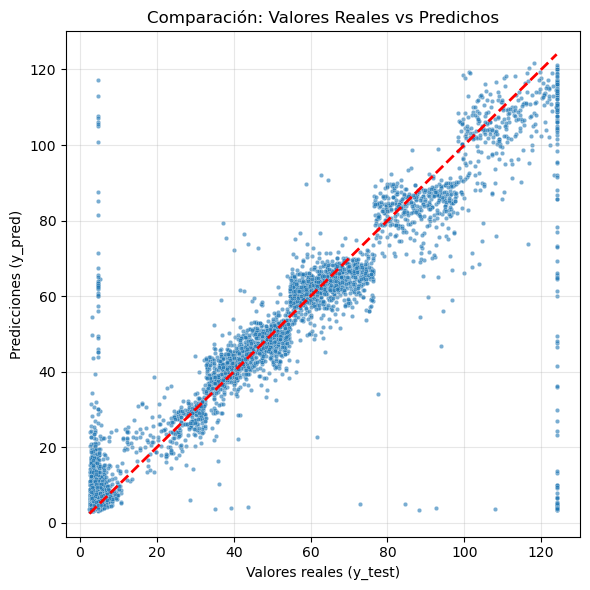

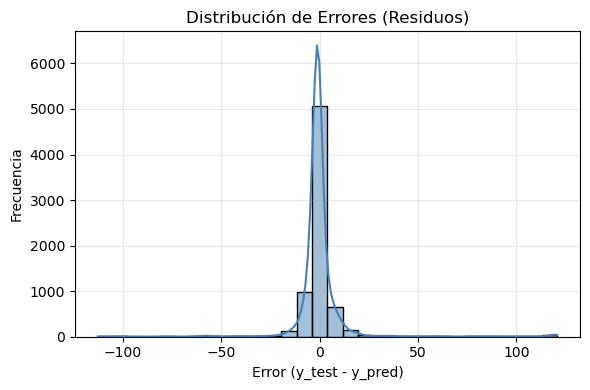

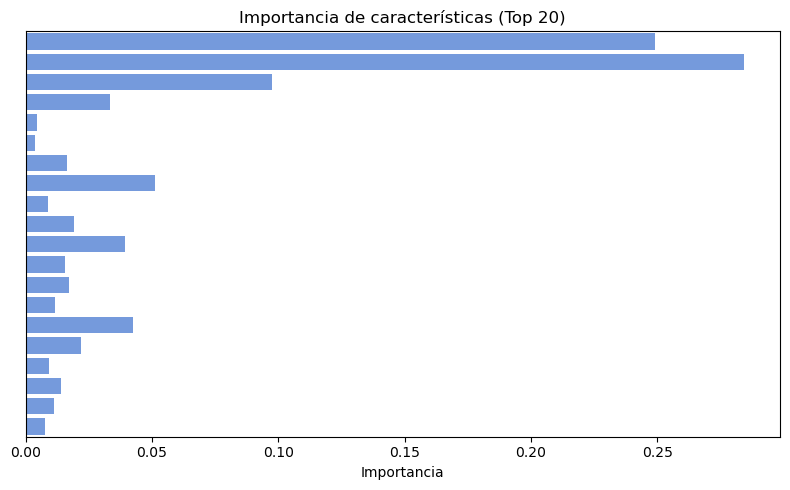


 Reportes de métricas guardados en:
 - C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\reports\rf_final_metrics.csv
 - C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\reports\rf_final_metrics.json


In [5]:
# EVALUACIÓN DE RENDIMIENTO DEL MODELO FINAL (Etiqueta: eval_model_metrics) 
# - Calcular métricas MAE, RMSE, R²
# - Generar visualizaciones de desempeño
# - Guarda resultados como artefactos reproducibles

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from joblib import load
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score
)

# ------------------------------------------------------
# 1 Cargar modelo optimizado y datos preprocesados
# ------------------------------------------------------
models_dir  = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\models")
reports_dir = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\reports")
data_dir    = Path(r"C:\Users\masalin2\OneDrive - Cisco\Desktop\MLOps_Proyect\data")

model_path = models_dir / "random_forest_optimized.pkl"
rf_model = load(model_path)
print(f"Modelo cargado desde: {model_path.name}")

X_test  = np.load(data_dir / "X_test_preprocessed.npy")
y_test  = np.load(data_dir / "y_test.npy")

# ------------------------------------------------------
# 2 Predicciones y métricas cuantitativas
# ------------------------------------------------------
y_pred = rf_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== MÉTRICAS DE DESEMPEÑO (Test) ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ------------------------------------------------------
# 3 Visualización 1: Real vs Predicho
# ------------------------------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, s=10, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación: Valores Reales vs Predichos")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 4 Visualización 2: Distribución de errores (residuos)
# ------------------------------------------------------
residuos = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuos, kde=True, color='steelblue', bins=30)
plt.title("Distribución de Errores (Residuos)")
plt.xlabel("Error (y_test - y_pred)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 5 Visualización 3: Importancia de características
# ------------------------------------------------------
try:
    importances = rf_model.feature_importances_
    # Limitar si hay demasiadas features
    n_features = min(len(importances), 20)
    plt.figure(figsize=(8, 5))
    sns.barplot(
        y=np.arange(n_features),
        x=importances[:n_features],
        orient='h',
        color="cornflowerblue"
    )
    plt.yticks([])
    plt.title("Importancia de características (Top 20)")
    plt.xlabel("Importancia")
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Este modelo no tiene atributo 'feature_importances_' (no aplica).")

# ------------------------------------------------------
# 6 Guardar métricas en CSV/JSON para trazabilidad
# ------------------------------------------------------
metricas = pd.DataFrame([{
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2
}])
metricas.to_csv(reports_dir / "rf_final_metrics.csv", index=False)
metricas.to_json(reports_dir / "rf_final_metrics.json", orient="records", indent=2)

print("\n Reportes de métricas guardados en:")
print(" -", reports_dir / "rf_final_metrics.csv")
print(" -", reports_dir / "rf_final_metrics.json")
